### Evaluate the NVSim ECC Implementation

From our analysis, we're using the parity matrix (P) and bias vector (b) that have been implemented in NVSim to exhibit the timing side-channel behavior we observe in memory write operations.

This notebook demonstrates the following:
- Construction of the generator matrix (G) from the P matrix and b vector used in NVSim
- Generation of codewords using the NVSim ECC parameters
- Analysis of transition patterns and their correlation with timing behavior
- Visualization of Sierpinski patterns using the same color scheme as visualize_sierpinski.py

In [6]:
from galois import GF2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product
from dataclasses import dataclass
from enum import Enum, auto
import seaborn as sns
from sklearn.mixture import GaussianMixture

# Set solution - updated to use correct file paths
best_solution_P = Path("P_matrix.csv").resolve()
best_solution_b = Path("b_vector.csv").resolve()

In [7]:
# Import P matrix and b vector from NVSim files, cast to GF2
P = GF2(np.loadtxt(best_solution_P, delimiter=',', dtype=np.uint8))
b = GF2(np.loadtxt(best_solution_b, delimiter=',', dtype=np.uint8))
k, r = P.shape
n = k + r
I_k = GF2.Identity(k) 
G = np.hstack([I_k, P])

# We don't need to generate syndromes in this script
#   but here's how you would construct H
I_r = GF2.Identity(r) 
H = np.hstack([P.T, I_r])

k_num_bytes = (k + 7) // 8
dt_m = np.dtype(f"u{k_num_bytes}")
dt_cw = np.dtype(f"u{k_num_bytes*2}")

print(f"Using the following parity matrix (P) from P_matrix.csv:")
display(P)
print(f"Using the following bias vector (b) from b_vector.csv:")
display(b)
print(f"df_ECC (n,k,r) \n\t = ({k+r}, {k}, {r})")
print(f"Inferred messgage dtype to be {dt_m}")
print(f"Inferred codeword dtype to be {dt_cw}")
print("Constructed the following generator matrix (G):")
display(G)
print("Constructed the following parity check matrix (H):")
display(H)

Using the following parity matrix (P) from P_matrix.csv:


GF([[0, 1, 1, 1, 1],
    [0, 0, 1, 1, 1],
    [1, 0, 1, 1, 1],
    [0, 1, 0, 1, 1],
    [0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 1, 0],
    [1, 0, 0, 0, 1],
    [0, 1, 0, 1, 0],
    [1, 1, 1, 0, 0],
    [1, 0, 0, 1, 0],
    [1, 0, 1, 0, 0]], order=2)

Using the following bias vector (b) from b_vector.csv:


GF([0, 0, 0, 0, 0], order=2)

df_ECC (n,k,r) 
	 = (21, 16, 5)
Inferred messgage dtype to be uint16
Inferred codeword dtype to be uint32
Constructed the following generator matrix (G):


GF([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Constructed the following parity check matrix (H):


GF([[0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]],
   order=2)

In [8]:
# Generate messages - this example is for the Sierpinski codewords
M = []

all_data = product(
     [i for i in range(256)], # from byte
     [i for i in range(256)], # to byte
     [0, 8],                  # the start of the transitioning byte in the word
     [0x00, 0xFF]             # the value of the non-transitioning byte
)

for from_m_B, to_m_B, m_pos, other_B in all_data:
     m0, m1 = [int.from_bytes(dt_m.itemsize*[other_B])]*2
     m0 = (m0 & ~(0xFF << m_pos)) | (from_m_B << m_pos)
     m1 = (m1 & ~(0xFF << m_pos)) | (to_m_B << m_pos)
     M.append((m0,m1,from_m_B,to_m_B,m_pos,other_B))
     
M = pd.DataFrame(
     data=M,
     columns=[
          # m0, m1 are reqired
          "m0",
          "m1",
          # Below is only used to simplify Sierpinski plotting
          "m0_B",      
          "m1_B", 
          "m_byte_offset", 
          "other_byte"
     ]
)

display(M)

,m0,m1,m0_B,m1_B,m_byte_offset,other_byte
0,0,0,0,0,0,0
1,65280,65280,0,0,0,255
2,0,0,0,0,8,0
3,255,255,0,0,8,255
4,0,1,0,1,0,0
...,...,...,...,...,...,...
262139,65535,65279,255,254,8,255
262140,255,255,255,255,0,0
262141,65535,65535,255,255,0,255
262142,65280,65280,255,255,8,0


In [9]:
# Use Galois to construct codewords in GF2, then cast back to ints
def util_ints2gf2(
    arr: np.array # Must have the appropriate type!
):
    nbytes = arr.dtype.itemsize
    ar_bytes = arr.view(np.uint8).reshape(-1, nbytes)
    return GF2(np.unpackbits(ar_bytes, axis=1, bitorder='little'))

def util_gf22ints(
    arr: np.array # Must be order 2
):  
    arr_bytes = np.array(arr, np.uint8)
    arr_packed = np.packbits(arr_bytes, axis=1, bitorder='little')
    return np.array([int.from_bytes(row.tobytes()) for row in arr_packed])

num_transitions = M.shape[0]
m0_gf2 = util_ints2gf2(np.array(M.m0).astype(dt_m))
cw0_gf2 = m0_gf2 @ G + GF2([[0]*k+list(b)]*num_transitions)
cw0_ints = util_gf22ints(cw0_gf2)

m1_gf2 = util_ints2gf2(np.array(M.m1).astype(dt_m))
cw1_gf2 = m1_gf2 @ G + GF2([[0]*k+list(b)]*num_transitions)
cw1_ints = util_gf22ints(cw1_gf2)

In [10]:
# Add the codwords to our dataframe
df_ECC = M
df_ECC['cw0'] = cw0_ints
df_ECC['cw1'] = cw1_ints
display(df_ECC)

,m0,m1,m0_B,m1_B,m_byte_offset,other_byte,cw0,cw1
0,0,0,0,0,0,0,0,0
1,65280,65280,0,0,0,255,65305,65305
2,0,0,0,0,8,0,0,0
3,255,255,0,0,8,255,16711686,16711686
4,0,1,0,1,0,0,0,65566
...,...,...,...,...,...,...,...,...
262139,65535,65279,255,254,8,255,16776991,16776724
262140,255,255,255,255,0,0,16711686,16711686
262141,65535,65535,255,255,0,255,16776991,16776991
262142,65280,65280,255,255,8,0,65305,65305


In [11]:
# Now we can compute the Sierpinski heuristic, 
#   but first we define our timing labels
class TransitionClass(Enum):
    """
    Timing labels.
    """
    NONE  = auto()
    UNIPOLAR = auto()
    BIPOLAR = auto()

# Per-row bit-change masks
up   = ((~cw0_ints) & cw1_ints)
down = (cw0_ints & (~cw1_ints))

# Booleans for each transition type
has_up   = up != 0
has_down = down != 0

is_bipolar  = has_up & has_down
is_unipolar = has_up ^ has_down
is_none     = ~(has_up | has_down)

# Map to enum labels (vectorized)
out = np.full(cw0_ints.shape, TransitionClass.NONE, dtype=object)
out[is_unipolar] = TransitionClass.UNIPOLAR
out[is_bipolar]  = TransitionClass.BIPOLAR

df_ECC["timing_label_from_P"] = out
display(df_ECC)

,m0,m1,m0_B,m1_B,m_byte_offset,other_byte,cw0,cw1,timing_label_from_P
0,0,0,0,0,0,0,0,0,TransitionClass.NONE
1,65280,65280,0,0,0,255,65305,65305,TransitionClass.NONE
2,0,0,0,0,8,0,0,0,TransitionClass.NONE
3,255,255,0,0,8,255,16711686,16711686,TransitionClass.NONE
4,0,1,0,1,0,0,0,65566,TransitionClass.UNIPOLAR
...,...,...,...,...,...,...,...,...,...
262139,65535,65279,255,254,8,255,16776991,16776724,TransitionClass.UNIPOLAR
262140,255,255,255,255,0,0,16711686,16711686,TransitionClass.NONE
262141,65535,65535,255,255,0,255,16776991,16776991,TransitionClass.NONE
262142,65280,65280,255,255,8,0,65305,65305,TransitionClass.NONE


In [12]:
# Before we plot it will be useful to map the transition label to a float
class_to_float = {
    TransitionClass.NONE:     0.0,
    TransitionClass.UNIPOLAR: 1.0,
    TransitionClass.BIPOLAR:  2.0,
}
df_ECC['timing_label_from_P_floats'] = np.vectorize(class_to_float.get)(df_ECC.timing_label_from_P)

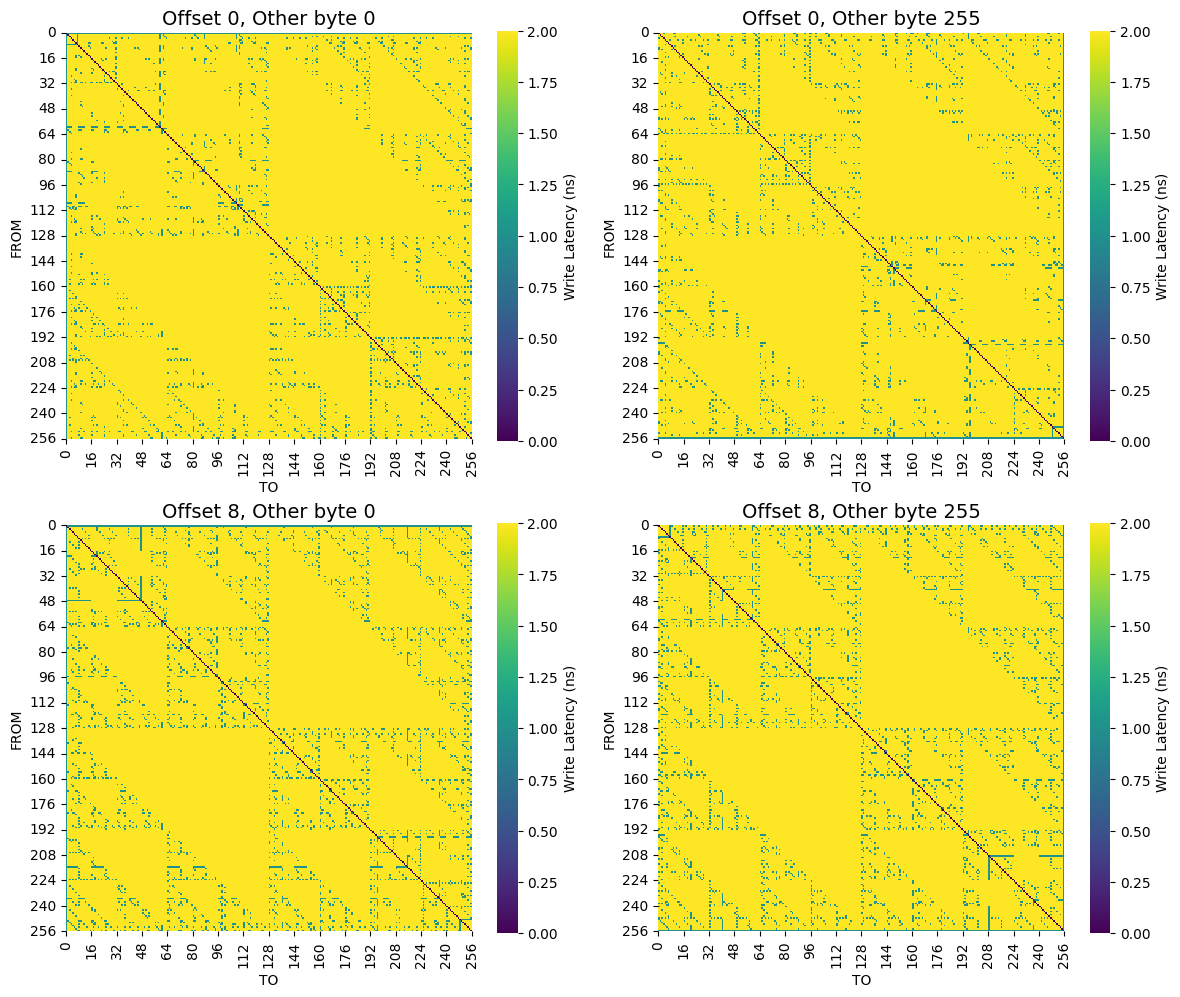

In [13]:
def plot_transition_heatmap(
    ax,
    heatmap_data,
    label,
    n=256
):
    sns.heatmap(ax=ax,
                data=heatmap_data,
                cmap='viridis',  # Changed from 'coolwarm' to match visualize_sierpinski.py
                square=True,     # Added for consistency with visualize_sierpinski.py
                cbar_kws={'label': label})
    ax.set_xlabel("TO")
    ax.set_ylabel("FROM")
    ax.set_xticks([i for i in range(0,n+1,16)])
    ax.set_xticklabels([i for i in range(0,n+1,16)])
    ax.set_yticks([i for i in range(0,n+1,16)])
    ax.set_yticklabels([i for i in range(0,n+1,16)])

fig, axs = plt.subplots(2,2,figsize=(12,10))
# Plot the Sierpinskis from the extracted parity function
for ((label, df_sub), ax) in zip(df_ECC.groupby(['m_byte_offset','other_byte']), axs.flatten()):
    heatmap_data = df_sub.pivot(index='m1_B', columns='m0_B', values='timing_label_from_P_floats')
    plot_transition_heatmap(
        ax,
        heatmap_data,
        label=r'Write Latency (ns)',  # Updated label to match visualize_sierpinski.py
        n=256
    )
    ax.set_title(
        f"Offset {label[0]}, Other byte {label[1]}",
        fontsize=14  # Added font size for consistency
    )

plt.tight_layout()

#### Comparison

Here we reconstruct the Sierpinski from the raw data we used to build our parity matrix and compare to our SAT result.

If we properly constrained the solver, our reconstructed Sierpinski above should perfectly map to UNIPOLAR, BIPOLAR, and NONE transition classes.

In [ ]:
# Import and clean up a bit

raw_data_paths = Path("./msmts_4Mb/").glob("*.csv")
df_raw = pd.concat([
    pd.read_csv(raw_data_path)
    for raw_data_path in raw_data_paths
])[["FROM_B", "TO_B", "EVEN", "OTHER", "WRITETIME_TICKS", "ADDR"]]

# For consistency
df_raw["m0_B"] = df_raw["FROM_B"]
df_raw["m1_B"] = df_raw["TO_B"]
df_raw["m_byte_offset"] = df_raw["EVEN"].map({True: 0, False: 8})
df_raw["other_byte"] = df_raw["OTHER"].map({0: 0x00, 1: 0xFF})

# Clean data (minsub for each ADDR, then min for each transition)
df_raw["WRITETIME_MINSUB"] = df_raw["WRITETIME_TICKS"] - df_raw.groupby(["ADDR"])['WRITETIME_TICKS'].transform('min')

df_msmt_clean = df_raw.groupby(["m_byte_offset", "other_byte", "m0_B", "m1_B"]).apply('min').reset_index()
fig, axs = plt.subplots(2,2,figsize=(12,10))
# Plot the Sierpinskis from the raw data - now with consistent styling
for ((label, df_sub), ax) in zip(df_msmt_clean.groupby(['m_byte_offset','other_byte']), axs.flatten()):
    heatmap_data = df_sub.pivot(index='m1_B', columns='m0_B', values='WRITETIME_MINSUB')
    plot_transition_heatmap(
        ax,
        heatmap_data,
        label=r'Write Latency (ns)',  # Updated label to match visualize_sierpinski.py
        n=256
    )
    ax.set_title(
        f"Offset {label[0]}, Other byte {label[1]}",
        fontsize=14  # Added font size for consistency
    )

plt.tight_layout()

ValueError: No objects to concatenate

Text(0.5, 1.0, 'Writetime Clustering')

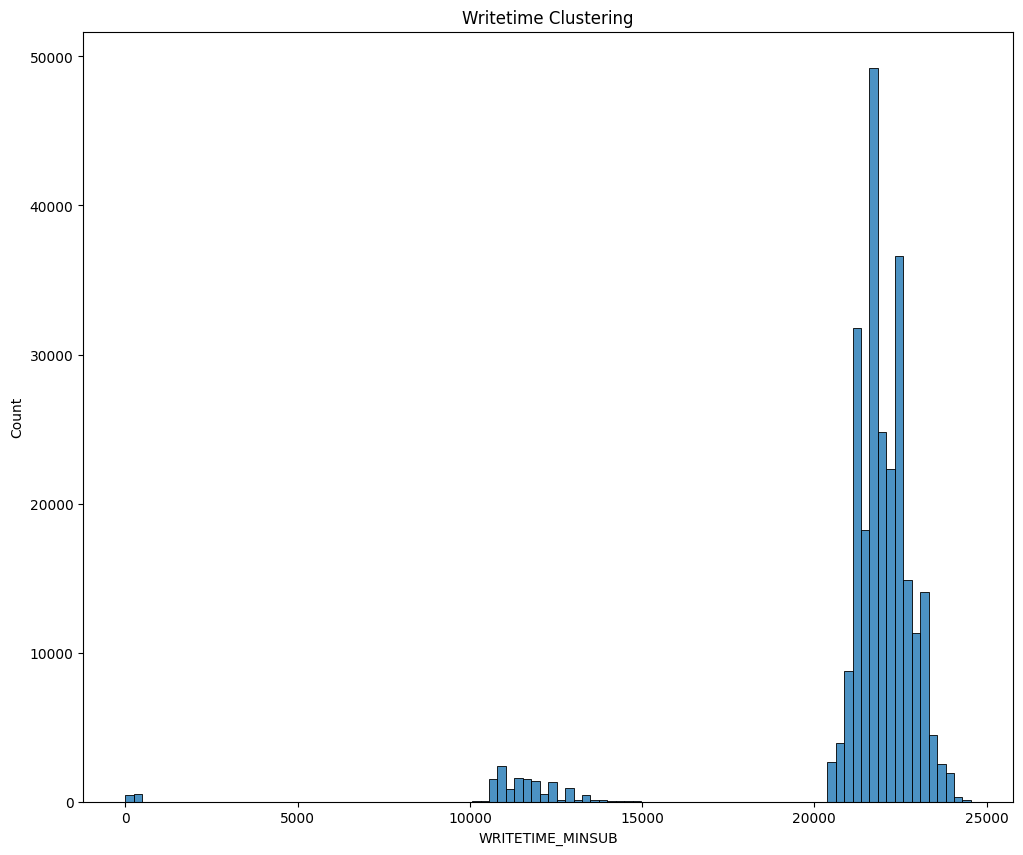

In [10]:
# Here's the key observation from before (T_NONE < T_UNIPOLAR < T_BIPOLAR)
#   Some UNIPOLARs become BIPOLAR --> df_ECC
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.histplot(
    ax=ax, 
    data=df_msmt_clean, 
    x='WRITETIME_MINSUB',  
    bins=100, 
    alpha=0.8
)
ax.set_title('Writetime Clustering')

In [11]:
# Now, let's assign each write time to a cluster depending on polarity
X = df_msmt_clean['WRITETIME_MINSUB'].values.reshape(-1, 1)

gmm = GaussianMixture(
    n_components=3,
    covariance_type="full",
    n_init=10,
    reg_covar=1e-6,
    random_state=0
).fit(X)

means = gmm.means_.ravel()
order = np.argsort(means)
labels = order[gmm.predict(X)]

name_by_idx = {
    0: TransitionClass.NONE, 
    1: TransitionClass.UNIPOLAR, 
    2: TransitionClass.BIPOLAR
}
named = np.vectorize(name_by_idx.get)(labels)

df_msmt_clean['timing_label_from_msmts'] = named
display(df_msmt_clean)

,m_byte_offset,other_byte,m0_B,m1_B,FROM_B,TO_B,EVEN,OTHER,WRITETIME_TICKS,ADDR,WRITETIME_MINSUB,timing_label_from_msmts
0,0,0,0,0,0,0,True,0,55439,42240,0,TransitionClass.NONE
1,0,0,0,1,0,1,True,0,68023,42240,12480,TransitionClass.UNIPOLAR
2,0,0,0,2,0,2,True,0,67503,42240,11960,TransitionClass.UNIPOLAR
3,0,0,0,3,0,3,True,0,66983,42240,11440,TransitionClass.UNIPOLAR
4,0,0,0,4,0,4,True,0,68023,42240,12480,TransitionClass.UNIPOLAR
...,...,...,...,...,...,...,...,...,...,...,...,...
262139,8,255,255,251,255,251,False,1,66151,379648,10608,TransitionClass.UNIPOLAR
262140,8,255,255,252,255,252,False,1,66359,379648,10816,TransitionClass.UNIPOLAR
262141,8,255,255,253,255,253,False,1,66359,379648,10816,TransitionClass.UNIPOLAR
262142,8,255,255,254,255,254,False,1,66359,379648,10816,TransitionClass.UNIPOLAR


Text(0.5, 1.0, 'Writetime Clustering')

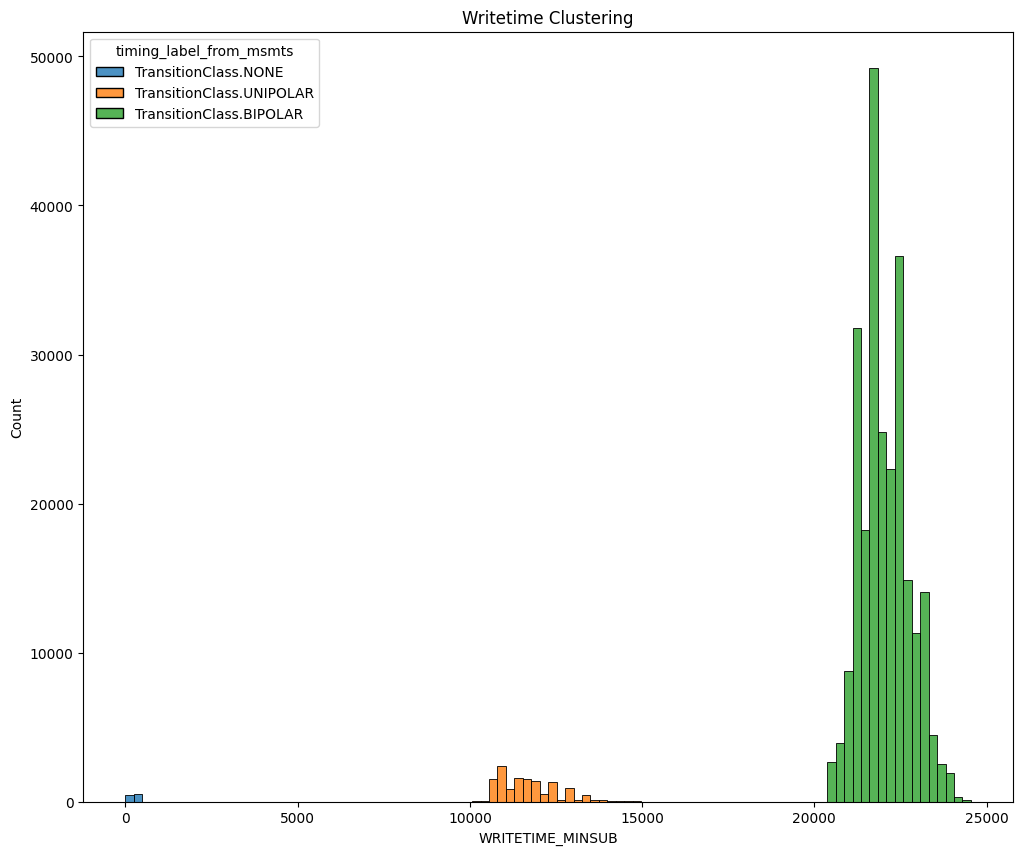

In [12]:
# Check that clustering worked
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.histplot(
    ax=ax, 
    data=df_msmt_clean, 
    x='WRITETIME_MINSUB',  
    bins=100, 
    alpha=0.8,
    hue="timing_label_from_msmts"
)
ax.set_title('Writetime Clustering')

In [ ]:
# Plot the Sierpinski purely based on cluster as we did with the parity timing model above
fig, axs = plt.subplots(2,2,figsize=(12,10))

class_to_float = {
    TransitionClass.NONE:     0.0,
    TransitionClass.UNIPOLAR: 1.0,
    TransitionClass.BIPOLAR:  2.0,
}
df_msmt_clean['timing_label_from_msmts_floats'] = np.vectorize(class_to_float.get)(df_msmt_clean.timing_label_from_msmts)

# Plot the Sierpinskis from the extracted parity function - now with consistent styling
for ((label, df_sub), ax) in zip(df_msmt_clean.groupby(['m_byte_offset','other_byte']), axs.flatten()):
    heatmap_data = df_sub.pivot(index='m1_B', columns='m0_B', values='timing_label_from_msmts_floats')
    plot_transition_heatmap(
        ax,
        heatmap_data,
        label=r'Write Latency (ns)',  # Updated label to match visualize_sierpinski.py
        n=256
    )
    ax.set_title(
        f"Offset {label[0]}, Other byte {label[1]}",
        fontsize=14  # Added font size for consistency
    )

plt.tight_layout()

In [ ]:
# Now finally take the difference between the plots (should only be gray!)
df_ECC = df_ECC.sort_values(['m0_B', 'm1_B']).reset_index(drop=True)
df_msmt_clean = df_msmt_clean.sort_values(['m0_B', 'm1_B']).reset_index(drop=True)
display(df_msmt_clean)
df_msmt_clean["DIFF"] = df_ECC['timing_label_from_P_floats']-df_msmt_clean['timing_label_from_msmts_floats']

df_ECC_gb = df_ECC.groupby(['m_byte_offset','other_byte'])

fig, axs = plt.subplots(2,2,figsize=(12,10))
# Plot the Sierpinskis of the diff - now with consistent styling
for ((label, df_sub), ax) in zip(df_msmt_clean.groupby(['m_byte_offset','other_byte']), axs.flatten()):
    heatmap_data = df_sub.pivot(index='m1_B', columns='m0_B', values='DIFF')
    plot_transition_heatmap(
        ax,
        heatmap_data,
        label=r'Difference',  # Updated label for difference plot
        n=256
    )
    ax.set_title(
        f"Offset {label[0]}, Other byte {label[1]}",
        fontsize=14  # Added font size for consistency
    )

plt.tight_layout()

#### Sahil's TODO

In [ ]:
# TODO: Sahil's challenge: 
# - Use NVSim to generate an identical Sierpinski trace
# - Using only codeword columns "cw0"/"cw1" and NVSIM,
#   generate a column identical to timing_label_from_P.

# NOTE: NVSim should have hamming weight built-in, 
#       so there will be a checkerboard pattern, 
#       that's actually great, but the cluster assignment
#       should still match!

# You're stuff here